<a href="https://colab.research.google.com/github/OnurKerimoglu/Colab_Notebooks/blob/master/Computer_Vision_with_TF_fashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_datasets as tfds

In [2]:
#this is how we split the train set for validation (and use the test only for testing really)
(dataset_train_original_nosup,dataset_validate_original_nosup,dataset_test_original_nosup), info = tfds.load(
    "fashion_mnist",
    split = ["train[:80%]", "train[80%:]","test"],
    as_supervised = False, #with this, each sample will be a dictionary of image, label, and potetially other features
    with_info = True
)
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incomplete37PELK/fashion_mnist-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/fashion_mnist/3.0.1.incomplete37PELK/fashion_mnist-test.tfrecord*...:   0%|   …

Dataset fashion_mnist downloaded and prepared to ~/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='~/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author  

In [3]:
#with as_supervised =False, take() returns samples as dictionaries
for sample in dataset_train_original_nosup.take(1):
  print(type(sample),sample.keys())

<class 'dict'> dict_keys(['image', 'label'])


In [4]:
#this is how we split the train set for validation (this is ok if all we want to do validation)
(dataset_train_original,dataset_validate_original), info = tfds.load(
    "fashion_mnist",
    split = ["train","test"],
    as_supervised = True, # with this, each sample will be an x, y pair
    with_info = True
)
info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='~/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author  

In [5]:
#now (as_supervised = True) we the take() does not return sample dictionaries
for sample in dataset_train_original.take(1):
  print(type(sample),sample.keys())

AttributeError: ignored

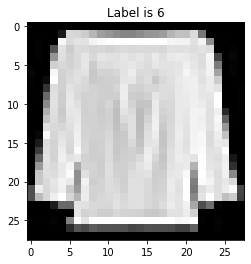

In [6]:
#instead, it returns directly x and y 
for x,y in dataset_train_original.shuffle(100).take(1):
  plt.imshow(x.numpy().squeeze(),cmap="gray")
  plt.title(f"Label is {y}")

# Data Preprocessing

1.0


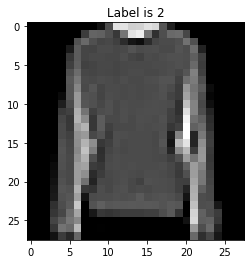

In [7]:
def encode(image,label):
  #this call converts to float, but also normalizes (min-max) becomes (0-1):
  image = tf.image.convert_image_dtype(image,dtype=tf.float32)
  return image, label

dataset = dataset_train_original.map(lambda image, label:encode(image,label))

for x,y in dataset.take(1):
  plt.imshow(x.numpy().squeeze(),cmap="gray")
  plt.title(f"Label is {y}")
  print(np.max(x.numpy()))

In [8]:
#processing steps that will be execuded with each take() call. But by using cache(), the encoding happens only once
dataset_train = dataset_train_original.map(lambda image, label: encode(image,label)).cache().shuffle(60000).batch(128)
dataset_validate = dataset_validate_original.map(lambda image, label: encode(image,label)).cache().batch(128)

In [9]:
for x_batch,y_batch in dataset_train.take(1):
  print(x_batch.shape)

(128, 28, 28, 1)


# Define the model, loss, optimizer

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(
    8, #number of different kernels to use (or channels). This is a tunable hyperparameter 
    (3,3), #kernel size. Again, tunable hp 
    activation = "relu", #here we just need a nonlinear act function. relu is fast, so better than sigmoid
    input_shape = (28,28,1)
    )) 
    #note that after the convolution we expanded our original data size:
    # output shape of the conv layer = (26,26,8) whereas the original was (28,28,1))
    # so we can think of convolution layer as feature engineering (addition) 
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(16, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(32, (3,3), activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dense(10,activation="softmax"))
model.summary()

model.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
 flatten (Flatten)           (None, 288)               0

In [11]:
def render_history(history):
    plt.title("Losses")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.title("Accuracies")
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

Epoch 1/20
469/469 [==============================] - 12s 7ms/step - loss: 0.7943 - accuracy: 0.7119 - val_loss: 0.5529 - val_accuracy: 0.8000
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.5010 - accuracy: 0.8185 - val_loss: 0.4824 - val_accuracy: 0.8269
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 0.4376 - accuracy: 0.8431 - val_loss: 0.4464 - val_accuracy: 0.8402
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.4039 - accuracy: 0.8560 - val_loss: 0.4141 - val_accuracy: 0.8525
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3786 - accuracy: 0.8657 - val_loss: 0.3937 - val_accuracy: 0.8583
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3590 - accuracy: 0.8709 - val_loss: 0.3924 - val_accuracy: 0.8595
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3445 - accuracy: 0.8756 - val_loss: 0.3678 - val_accuracy: 0.8696
Epoch

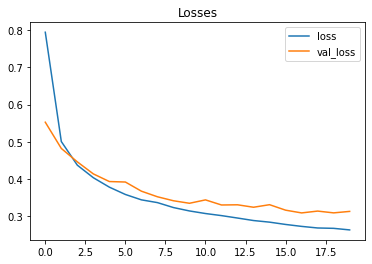

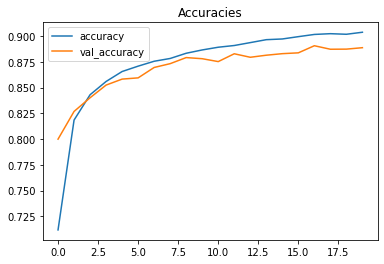

In [12]:
history = model.fit(
    dataset_train,
    validation_data = dataset_validate,
    epochs = 20
)
render_history(history)